<a href="https://colab.research.google.com/github/misko/spf/blob/main/02_beamformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

c=3e8 # speed of light

class Source(object):
  def __init__(self,pos):
    self.pos=np.array(pos)

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times)+np.sin(2*np.pi*sampling_times)*1j

class SinSource(Source):
  def __init__(self,pos,frequency,phase):
    super().__init__(pos)
    self.frequency=frequency
    self.phase=phase

  def signal(self,sampling_times):
    return np.cos(2*np.pi*sampling_times*self.frequency+self.phase)+np.sin(2*np.pi*sampling_times*self.frequency+self.phase)*1j

class Receiver:
  def __init__(self,pos):
    self.pos=np.array(pos)

class Detector(object):
  def __init__(self,sampling_frequency):
    self.sources=[]
    self.receivers=[]
    self.sampling_frequency=sampling_frequency

  def add_source(self,source):
    self.sources.append(source)

  def add_receiver(self,receiver):
    self.receivers.append(receiver)

  def get_signal_matrix(self,start_time,duration):
    n_samples=int(duration*self.sampling_frequency)
    base_times=start_time+np.linspace(0,n_samples-1,n_samples)/self.sampling_frequency
    sample_matrix=np.zeros((len(self.receivers),n_samples),dtype=np.cdouble) # receivers x samples
    for receiver_index,receiver in enumerate(self.receivers):
      for _source in self.sources:
        time_delay=np.linalg.norm(receiver.pos-_source.pos)/c
        sample_matrix[receiver_index,:]+=_source.signal(base_times-time_delay)
    return sample_matrix

  

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


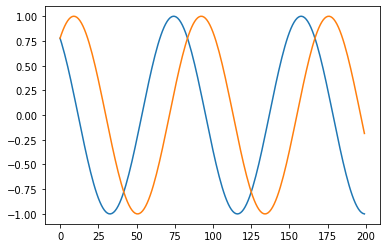

In [ ]:
def beamformer(detector,signal_matrix,carrier_frequency):
  thetas=np.linspace(0,2*np.pi,180)
  steer_dot_signal=np.zeros(thetas.shape[0])
  carrier_wavelength=c/carrier_frequency
  for theta_index,theta in enumerate(thetas):
    source_vector=np.array([np.cos(theta),np.sin(theta)])
    steering_vector=np.zeros(len(detector.receivers)).astype(np.cdouble)
    projections=[]
    for receiver_index,receiver in enumerate(detector.receivers):
      projection_of_receiver_onto_source_direction=np.dot(source_vector,receiver.pos)
      projections.append(projection_of_receiver_onto_source_direction/carrier_wavelength)
      arg=2*np.pi*projection_of_receiver_onto_source_direction/carrier_wavelength
      steering_vector[receiver_index]=np.cos(-arg)+np.sin(-arg)*1j
    steer_dot_signal[theta_index]=np.absolute(np.matmul(steering_vector,signal_matrix)).mean()
  return thetas,steer_dot_signal
  

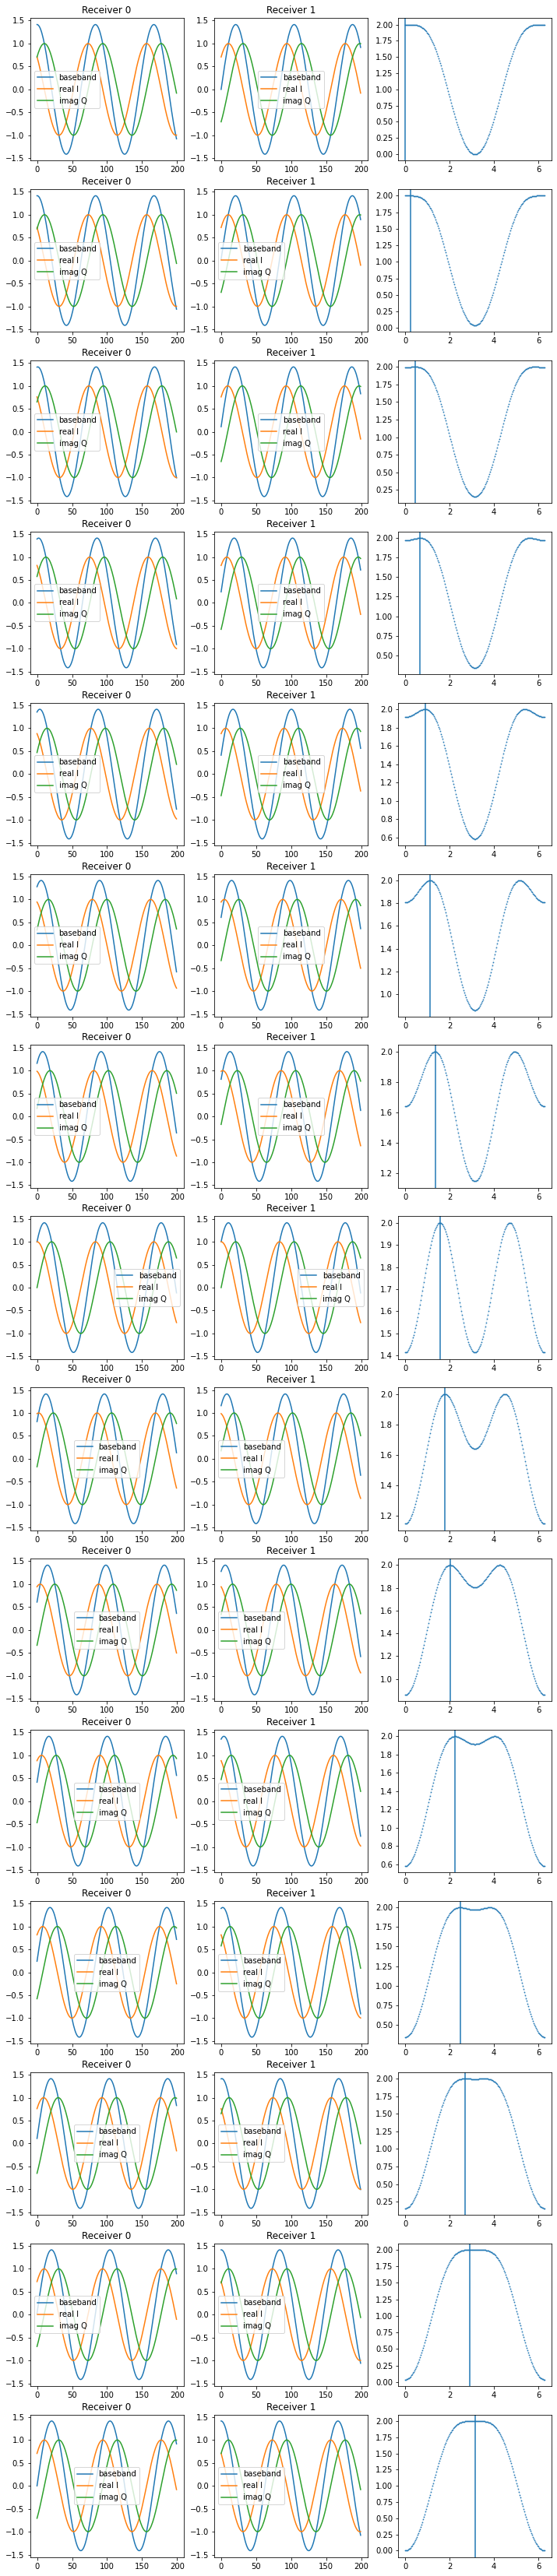

In [ ]:
def iq_to_real(i,q):
  return np.cos(i)+np.sin()

n=15
fig,axs=plt.subplots(n,3,figsize=(4*3,4*n))

for theta_idx,theta in enumerate(np.linspace(0,np.pi,n)):
  d=Detector(1e6) # 1Mhz sampling
  sin_source_frequency=12e3 # 10khz signal 
  wavelength=c/sin_source_frequency

  d.add_source(SinSource([
      wavelength*100000*np.cos(theta),
      wavelength*100000*np.sin(theta)],
      sin_source_frequency,0))
  
  d.add_receiver(Receiver([wavelength/8,0]))
  d.add_receiver(Receiver([-wavelength/8,0]))

  z=d.get_signal_matrix(0,200/1e6) 


  beam_thetas,beam_sds=beamformer(d,z,sin_source_frequency)

  #lets plot the raw signal
  for idx in range(z.shape[0]):
    axs[theta_idx][idx].plot(z[idx].real+z[idx].imag,label='baseband')
    axs[theta_idx][idx].plot(z[idx].real,label='real I')
    axs[theta_idx][idx].plot(z[idx].imag,label='imag Q')
    axs[theta_idx][idx].legend()
    axs[theta_idx][idx].set_title("Receiver %d" % idx)
  
  axs[theta_idx][z.shape[0]].plot(beam_thetas,beam_sds,alpha=0.1)
  axs[theta_idx][z.shape[0]].scatter(beam_thetas,beam_sds,s=0.5)
  axs[theta_idx][z.shape[0]].axvline(x=theta)